<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 7

## NLP and Machine Learning on [travel.statsexchange.com](http://travel.stackexchange.com/) data

---

In Project 7 you'll be doing NLP and machine learning on post data from stackexchange's travel subdomain. 

This project is setup like a mini Kaggle competition. You are given the training data and when projects are submitted your model will be tested on the held-out testing data. There will be prizes for the people who build models that perform best on the held out test set!

---

## Notes on the data

The data is again compressed into the `.7z` file format to save space. There are 6 .csv files and one readme file that contains some information on the fields.

    posts_train.csv
    comments_train.csv
    users.csv
    badges.csv
    votes_train.csv
    tags.csv
    readme.txt
    
The data is located in your datasets folder:

    DSI-SF-2/datasets/stack_exchange_travel.7z
    
If you're interested in where this data came from and where to get more data from other stackexchange subdomains, see here:

https://ia800500.us.archive.org/22/items/stackexchange/readme.txt


### Recommended Utilities for .7z

- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use LDA to find what topics are discussed on travel.stackexchange.com.

---

Text can be found in the posts and the comments datasets. The `ParentId` column in the posts dataset indicates what the "question" post was for a given post. Comment text can be merged onto the post they are part of with the `PostId` field.

The text may have some HTML tags. BeautifulSoup has convenient ways to get rid of markup or extract text if you need to. You can also parse the strings yourself if you like.

The tags dataset has the "tags" that the users have officially given the post.

**1.1 Implement LDA against the text features of the dataset(s).**

- This can be posts or a combination of posts and comments if you want more power.
- Find optimal **K/num_topics**.

**1.2 Compare your topics to the tags. Do the LDA topics make sense? How do they compare to the tags?**


In [331]:
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor,ExtraTreesRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
plt.style.use('fivethirtyeight')
from ipywidgets import *
from IPython.display import display
%matplotlib inline

In [273]:
filename = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/stack_exchange_travel/posts_train.csv'
df = pd.read_csv(filename)
df.head(2)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,NaN,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0
1,NaN,1.0,<p>Singapore Airlines has an all-business clas...,NaN,1,NaN,2011-06-21T20:24:57.160,NaN,4,2013-01-09T09:55:22.743,...,NaN,693.0,NaN,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,219.0


In [4]:
filename = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/stack_exchange_travel/comments_train.csv'
df2 = pd.read_csv(filename)
df2.head(2)

,CreationDate,Id,PostId,Score,Text,UserDisplayName,UserId
0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,NaN,12.0
1,2011-06-21T20:27:35.300,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",NaN,9.0


In [13]:
coms = df2.groupby(['PostId'])[['Text']].agg(lambda x: x.tolist()).reset_index()
coms.rename(columns={'PostId':'post_id','Text': 'message_text'}, inplace=True)

In [6]:
coms.iloc[530,1]

['I take pictures of signs. Many, many pictures of signs. They are super helpful for identifying the subjects of the surrounding pictures when I get home. Some of them have value of their own as well, but most are just notes to myself. For example the Venice churches all had standard nameplates on the outside and I took pictures of them knowing the churches would start to blur together for me.',
 "I normally do but was hunting for a hostel at the time and didn't think to do it.  Def the best way to remember - can't always rely on the mind ;)"]

In [7]:
df.columns.values

array(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate',
       'CommentCount', 'CommunityOwnedDate', 'CreationDate',
       'FavoriteCount', 'Id', 'LastActivityDate', 'LastEditDate',
       'LastEditorDisplayName', 'LastEditorUserId', 'OwnerDisplayName',
       'OwnerUserId', 'ParentId', 'PostTypeId', 'Score', 'Tags', 'Title',
       'ViewCount'], dtype=object)

In [274]:
df.rename(columns={'ParentId':'parent_id', 'Id': 'post_id','Body':'body','Tags':'tags','Title':'title'}, inplace=True)

In [275]:
def tags_to_list(text):
    return str(text).replace('><',', ').replace('<','').replace('>','')

def serve_soup(row):
    soup = BeautifulSoup(str(row),'html.parser')
    new_row = soup.get_text()
    return new_row

def is_ascii(text):
    # death to weird chars
    new_text =  ''.join([i if ord(i) < 128 and ord(i) != 91 else '' for i in text])
    
    # throwing some additional attempts at clean up here
    new_text = " ".join(filter(lambda x:x[0]!='@', new_text.split()))
    new_text = " ".join(filter(lambda x:x[0:4]!='http', new_text.split()))
    
    # what is all this number junk? I'm pulling 'em
    return ''.join(['' if ord(i) > 46 and ord(i) < 58 else i for i in new_text])



In [276]:
df['tags_list'] = df['tags'].apply(tags_to_list) 
df['body_text'] = df['body'].apply(serve_soup)
df['body_text'] = df['body_text'].apply(is_ascii) 


In [157]:

posts = df[['post_id','body_text','tags_list','title']]

In [158]:
doc = pd.merge(posts,coms, on='post_id', how='inner')
doc['body_message_text'] = doc['body_text'] + doc['message_text'].map(str)
doc.head()

,post_id,body_text,tags_list,title,message_text
0,1,My fiance and I are looking for a good Caribbe...,"caribbean, cruising, vacations",What are some Caribbean cruises for October?,[To help with the cruise line question: Where ...
1,4,Singapore Airlines has an all-business class f...,"loyalty-programs, routes, ewr, singapore-airli...",Does Singapore Airlines offer any reward seats...,[This route (as well as LAX-SIN) is being canc...
2,8,Can anyone suggest the best way to get from Se...,"usa, airport-transfer, taxis, seattle",Best way to get from SeaTac airport to Redmond?,"[To those voting down, please explain why with..."
3,9,We are considering visiting Argentina for up t...,"sightseeing, public-transport, transportation,...",What are must-visit destinations for the first...,"[I agree with @user27478, you need to specify ..."
4,11,I'm planning on taking the trans-Siberian tra...,"russia, visas, china, mongolia, trans-siberian",What is the best way to obtain visas for the T...,"[If at all possible, save yourself the hassle ..."


In [91]:
documents = doc['body_message_text']
#documents.values
vectorizer = CountVectorizer(stop_words='english', max_features = 200)
X = vectorizer.fit_transform(documents)

In [98]:
vectorizer.vocabulary_

In [92]:
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [93]:
vocab = {v: k for k, v in vectorizer.vocabulary_.iteritems()}
vocab

{0: u'able',
 1: u'actually',
 2: u'air',
 3: u'airline',
 4: u'airlines',
 5: u'airport',
 6: u'allowed',
 7: u'answer',
 8: u'application',
 9: u'apply',
 10: u'area',
 11: u'ask',
 12: u'asked',
 13: u'asking',
 14: u'available',
 15: u'best',
 16: u'better',
 17: u'bit',
 18: u'book',
 19: u'booking',
 20: u'border',
 21: u'bus',
 22: u'business',
 23: u'buy',
 24: u'canada',
 25: u'car',
 26: u'card',
 27: u'carry',
 28: u'case',
 29: u'change',
 30: u'check',
 31: u'checked',
 32: u'citizen',
 33: u'city',
 34: u'come',
 35: u'company',
 36: u'cost',
 37: u'countries',
 38: u'country',
 39: u'course',
 40: u'credit',
 41: u'customs',
 42: u'date',
 43: u'day',
 44: u'days',
 45: u'did',
 46: u'didn',
 47: u'different',
 48: u'does',
 49: u'doesn',
 50: u'don',
 51: u'end',
 52: u'english',
 53: u'enter',
 54: u'entry',
 55: u'eu',
 56: u'europe',
 57: u'example',
 58: u'expensive',
 59: u'experience',
 60: u'far',
 61: u'fine',
 62: u'flight',
 63: u'flights',
 64: u'fly',
 65: u

In [94]:
frequency = defaultdict(int)

for text in documents:
    for t in text:
        frequency[t] += 1

texts = [[t for t in text if frequency[t] > 1] for text in documents]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [100]:
lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  5,
    passes      =  10,
    id2word     =  vocab
)

In [101]:
lda.print_topics(num_topics=5, num_words=5)

[(0, u'0.068*train + 0.049*xe + 0.043*bus + 0.035*london + 0.032*station'),
 (1, u'0.060*card + 0.037*car + 0.036*luggage + 0.029*check + 0.028*airport'),
 (2, u'0.029*like + 0.029*just + 0.029*question + 0.025*don + 0.024*people'),
 (3,
  u'0.111*visa + 0.049*passport + 0.032*uk + 0.031*schengen + 0.029*country'),
 (4,
  u'0.088*flight + 0.045*ticket + 0.041*airline + 0.037*flights + 0.033*airlines')]

In [103]:
lda.get_document_topics(corpus[0])

[(0, 0.080760596283730585),
 (1, 0.42224113026123195),
 (3, 0.43091559633670784),
 (4, 0.06589502389647646)]

In [108]:
# just for comparison
documents_t = doc['tags_list']
vectorizer_t = CountVectorizer(stop_words='english', max_features = 200)
X_t = vectorizer_t.fit_transform(documents_t)

vocab_t = {v: k for k, v in vectorizer_t.vocabulary_.iteritems()}

frequency_t = defaultdict(int)

for text in documents_t:
    for t in text:
        frequency_t[t] += 1

texts_t = [[t for t in text if frequency_t[t] > 1] for text in documents_t]

dictionary_t = corpora.Dictionary(texts_t)
corpus_t = [dictionary_t.doc2bow(text) for text in texts_t]

lda_t = models.LdaModel(
    matutils.Sparse2Corpus(X_t, documents_columns=False),
    num_topics  =  5,
    passes      =  10,
    id2word     =  vocab
)

In [109]:
lda_t.print_topics(num_topics=5, num_words=5)


[(0, u'0.215*way + 0.136*service + 0.094*date + 0.090*visa + 0.057*pretty'),
 (1, u'0.986*pass + 0.008*make + 0.003*booking + 0.000*card + 0.000*luggage'),
 (2,
  u'0.174*using + 0.126*airline + 0.061*note + 0.034*airport + 0.027*answer'),
 (3, u'0.108*way + 0.106*visas + 0.074*end + 0.067*know + 0.065*want'),
 (4, u'0.058*try + 0.052*use + 0.050*reason + 0.042*fly + 0.033*looking')]

In [ ]:
# not so dissimilar

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. What makes an answer likely to be "accepted"?

---

**2.1 Build a model to predict whether a post will be marked as the answer.**

- This is a classification problem.
- You're free to use any of the machine learning algorithms or techniques we have learned in class to build the best model you can.
- NLP will be very useful here for pulling out useful and relevant features from the data. 
- Though not required, using bagging and boosting models like Random Forests and Gradient Boosted Trees will _probably_ get you the highest performance on the test data (but who knows!).


**2.2 Evaluate the performance of your classifier with a confusion matrix and accuracy. Explain how your model is performing.**

**2.3 Plot either a ROC curve or precision-recall curve (or both!) and explain what they tell you about your model.**

NOTE: You should only be predicting this for `PostTypeID=2` posts, which are the "answer" posts. This doesn't mean, however, that you can't or shouldn't use the parent questions as predictors!


In [161]:
df.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'body', u'ClosedDate',
       u'CommentCount', u'CommunityOwnedDate', u'CreationDate',
       u'FavoriteCount', u'post_id', u'LastActivityDate', u'LastEditDate',
       u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName',
       u'OwnerUserId', u'parent_id', u'PostTypeId', u'Score', u'tags',
       u'title', u'ViewCount', u'tags_list', u'body_text'],
      dtype='object')

In [182]:
dfA = df[df['PostTypeId']==2]
dfAID = df[df['AcceptedAnswerId']>0]
ans_id = dfAID['AcceptedAnswerId'].tolist()

In [180]:
dfA['is_ans'] = dfA['post_id'].apply(lambda x: 1 if x in ans_id else 0)

/Users/katbishop/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [188]:
ans = dfA[dfA['is_ans']==1]
not_ans = dfA[dfA['is_ans']==0]

In [241]:
ans_text2 = ans['body_text']

ans_text=''
for i in ans_text2:
    ans_text += i

In [246]:
not_ans_text2 = not_ans['body_text']
not_ans_text=''
for i in not_ans_text2:
    not_ans_text += i

In [248]:
tvec = TfidfVectorizer(stop_words='english')
tvec.fit([ans_text,not_ans_text])

df  = pd.DataFrame(tvec.transform([ans_text,not_ans_text]).todense(), 
                   columns=tvec.get_feature_names(), index=['ans_text','not_ans_text'])

df.transpose().sort_values('ans_text', ascending=False).head(10).transpose()

,visa,time,need,travel,just,don,like,ticket,airport,day
ans_text,0.208882,0.180509,0.165078,0.150349,0.146269,0.138554,0.137916,0.129244,0.126949,0.121848
not_ans_text,0.302806,0.180475,0.181502,0.150270,0.158939,0.150754,0.136376,0.100251,0.108255,0.098166


In [249]:
df.transpose().sort_values('not_ans_text', ascending=False).head(10).transpose()

,visa,need,time,just,don,travel,country,like,passport,people
ans_text,0.208882,0.165078,0.180509,0.146269,0.138554,0.150349,0.121274,0.137916,0.089967,0.121338
not_ans_text,0.302806,0.181502,0.180475,0.158939,0.150754,0.150270,0.144410,0.136376,0.130154,0.123509


In [251]:
dfA.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'body', u'ClosedDate',
       u'CommentCount', u'CommunityOwnedDate', u'CreationDate',
       u'FavoriteCount', u'post_id', u'LastActivityDate', u'LastEditDate',
       u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName',
       u'OwnerUserId', u'parent_id', u'PostTypeId', u'Score', u'tags',
       u'title', u'ViewCount', u'tags_list', u'body_text', u'is_ans'],
      dtype='object')

In [266]:
X.isnull().sum()

AnswerCount      23967
CommentCount         0
FavoriteCount    23967
PostTypeId           0
Score                0
ViewCount        23967
dtype: int64

In [325]:
y = dfA['is_ans']
X = dfA[['CommentCount','PostTypeId', 'Score']]

print y.shape, X.shape

(23967,) (23967, 3)


In [326]:
dtc_params = {
    'max_depth':[1,2,3,4]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

dtc_gs.fit(X_train, y_train)
pred = dtc_gs.predict(X_test)

dtc_best = dtc_gs.best_estimator_
print dtc_gs.best_params_
print dtc_gs.best_score_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'max_depth': 4}
0.734203624225


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


In [327]:
fi = pd.DataFrame({
        'feature': X.columns,
        'importance': dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
2,Score,0.901329
0,CommentCount,0.098671
1,PostTypeId,0.000000


In [330]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

confmat = confusion_matrix(y_true=y_test, y_pred=pred)

confusion = pd.DataFrame(confmat, index=['is_not_ans', 'is_ans'],
                         columns=['predicted_is_not_ans','predicted_is_ans'])
#confusion = pd.DataFrame(confmat)
print(confusion)

            predicted_is_not_ans  predicted_is_ans
is_not_ans                  5070               115
is_ans                      1876               130


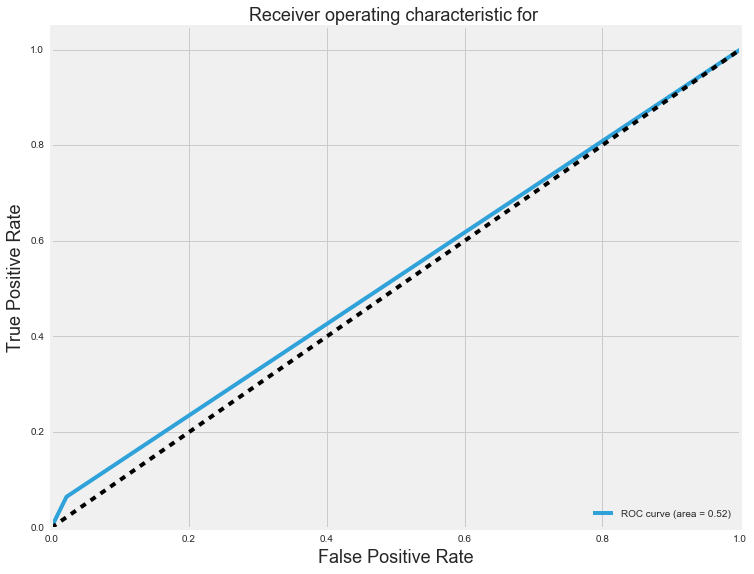

In [335]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(target=y_test, predict_proba=pred, title='')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. What is the score of a post?

---

**3.1 Build a model that predicts the score of a post.**

- This is a regression problem now. 
- You can and should be predicting score for both "question" and "answer" posts, so keep them both in your dataset.
- Again, use any techniques that you think will get you the best model.

**3.2 Evaluate the performance of your model with cross-validation and report the results.**

**3.3 What is important for determining the score of a post, if anything?**


In [278]:
df.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'body', u'ClosedDate',
       u'CommentCount', u'CommunityOwnedDate', u'CreationDate',
       u'FavoriteCount', u'post_id', u'LastActivityDate', u'LastEditDate',
       u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName',
       u'OwnerUserId', u'parent_id', u'PostTypeId', u'Score', u'tags',
       u'title', u'ViewCount', u'tags_list', u'body_text'],
      dtype='object')

In [301]:
df_nan_free = df[((df['AnswerCount']>0) & (df['OwnerUserId']>0))]

In [302]:
y = df_nan_free['Score']
X = df_nan_free[['AnswerCount','CommentCount',  'OwnerUserId',  'PostTypeId', 'ViewCount']]

print y.shape, X.shape

(12345,) (12345, 5)


In [303]:
X.isnull().sum()

AnswerCount     0
CommentCount    0
OwnerUserId     0
PostTypeId      0
ViewCount       0
dtype: int64

In [306]:
rfr = RandomForestRegressor(max_depth=3, n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
rfr.fit(X,y)
rfr_scores = cross_val_score(rfr, X, y, cv=5)

print 'rfr Reg: ', rfr_scores 
print 'rfr Mean: ', np.mean(rfr_scores)

rfr Reg:  [ 0.30603955  0.24275356  0.32573961  0.50088973  0.43528666]
rfr Mean:  0.362141821509


In [308]:
adc = AdaBoostRegressor()
adc.fit(X,y)
adc_scores = cross_val_score(adc, X, y, cv=5)

print 'adc Reg: ', adc_scores 
print 'adc Mean: ', np.mean(adc_scores)

adc Reg:  [ 0.25866601  0.12553363 -0.00744089  0.3468278   0.39900998]
adc Mean:  0.224519305713


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. How many views does a post have?

---

**4.1 Build a model that predicts the number of views a post has.**

- This is another regression problem. 
- Predict the views for all posts, not just the "answer" posts.

**4.2 Evaluate the performance of your model with cross-validation and report the results.**

**4.3 What is important for the number of views a post has, if anything?**

In [312]:
y = df_nan_free['ViewCount']
X = df_nan_free[['AnswerCount','CommentCount',  'OwnerUserId',  'PostTypeId', 'Score']]

print y.shape, X.shape

(12345,) (12345, 5)


In [311]:
X.isnull().sum()

AnswerCount     27301
CommentCount        0
OwnerUserId       737
PostTypeId          0
Score               0
dtype: int64

In [319]:
etr = ExtraTreesRegressor(max_depth=3, n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
etr.fit(X,y)
etr_scores = cross_val_score(etr, X, y, cv=5)

print 'etr Reg: ', etr_scores 
print 'etr Mean: ', np.mean(etr_scores)

etr Reg:  [ 0.05158709  0.09970374  0.08770317  0.18526133  0.07365493]
etr Mean:  0.0995820523025


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5. Build a pipeline or other code to automate evaluation of your models on the test data.

---

Now that you've constructed your three predictive models, build a pipeline or code that can easily load up the raw testing data and evaluate your models on it.

The testing data that is held out is in the same raw format as the training data you have. _Any cleaning and preprocessing that you did on the training data will need to be done on the testing data as well!_

This is a good opportunity to practice building pipelines, but you're not required to. Custom functions and classes are fine as long as they are able to process and test the new data.
